In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
#from sklearn.inspection import plot_partial_dependence
import shap
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, r2_score, matthews_corrcoef
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
import lime
import lime.lime_tabular
#from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier
#from sklearn.ensemble.partial_dependence import plot_partial_dependence
#from pyale import ale_plot
import warnings

warnings.filterwarnings("ignore")

In [3]:
# 1) Importation des données
X_train = pd.read_csv("data/X_train.csv", parse_dates=['DELIVERY_START'])
y_train = pd.read_csv("data/y_train.csv", parse_dates=['DELIVERY_START'])

In [4]:
# 2) Affichage des statistiques descriptives
print("Statistiques descriptives de X_train :")
print(X_train.describe())
print("\nStatistiques descriptives de y_train :")
print(y_train.describe())

Statistiques descriptives de X_train :
       load_forecast  coal_power_available  gas_power_available  \
count    9318.000000          10604.000000         10604.000000   
mean    53725.132968           2819.781592         11463.220671   
std     11274.194929            495.103588           483.799154   
min     30515.000000           1646.000000          9769.000000   
25%     45336.500000           2226.000000         11140.000000   
50%     51846.000000           2806.000000         11487.000000   
75%     62091.750000           3386.000000         11945.000000   
max     85145.000000           3391.000000         11963.000000   

       nucelear_power_available  wind_power_forecasts_average  \
count              10604.000000                  10581.000000   
mean               35393.282252                   4512.989415   
std                 7619.820162                   3349.419356   
min                22285.000000                    592.000000   
25%                29005.000000 

In [5]:
# 3) Affichage des informations
print("\nInformations de X_train :")
print(X_train.info())
print("\nInformations de y_train :")
print(y_train.info())



Informations de X_train :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10605 entries, 0 to 10604
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DELIVERY_START                 10605 non-null  object 
 1   load_forecast                  9318 non-null   float64
 2   coal_power_available           10604 non-null  float64
 3   gas_power_available            10604 non-null  float64
 4   nucelear_power_available       10604 non-null  float64
 5   wind_power_forecasts_average   10581 non-null  float64
 6   solar_power_forecasts_average  10581 non-null  float64
 7   wind_power_forecasts_std       10581 non-null  float64
 8   solar_power_forecasts_std      10581 non-null  float64
 9   predicted_spot_price           1846 non-null   float64
dtypes: float64(9), object(1)
memory usage: 828.6+ KB
None

Informations de y_train :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10605 en

In [9]:
# 4) Séparation des données
X_clean = X_train.dropna(subset=['predicted_spot_price'])
X_dirty = X_train[X_train['predicted_spot_price'].isnull()]

y_clean = pd.merge(X_clean[['DELIVERY_START']], y_train, how='inner', on='DELIVERY_START')
y_dirty = pd.merge(X_dirty[['DELIVERY_START']], y_train, how='inner', on='DELIVERY_START')


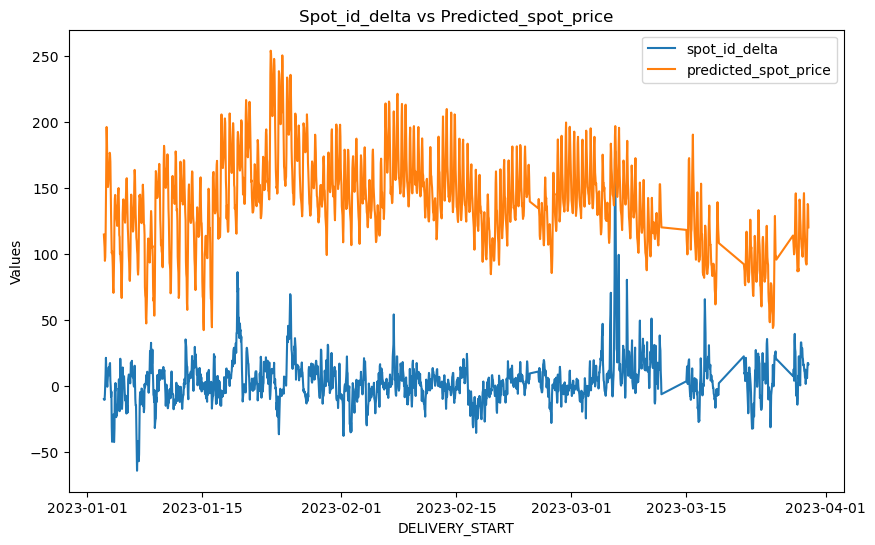

In [10]:

# 5) Affichage sur un même graphique des valeurs de y_clean et predicted_spot_price dans X_clean
plt.figure(figsize=(10, 6))
plt.plot(X_clean['DELIVERY_START'], y_clean['spot_id_delta'], label='spot_id_delta')
plt.plot(X_clean['DELIVERY_START'], X_clean['predicted_spot_price'], label='predicted_spot_price')
plt.xlabel('DELIVERY_START')
plt.ylabel('Values')
plt.title('Spot_id_delta vs Predicted_spot_price')
plt.legend()
plt.show()


In [29]:
# 6) Séparation des données en jeu d'entrainement et de test
X_clean = X_clean.dropna()
y_clean = pd.merge(X_clean[['DELIVERY_START']], y_clean, how='inner', on='DELIVERY_START')
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

In [42]:
X_mat_train = X_train_clean.drop(columns=['DELIVERY_START', 'predicted_spot_price']).values
X_mat_test = X_test_clean.drop(columns=['DELIVERY_START', 'predicted_spot_price']).values
# Calculer la somme de 'predicted_spot_price' de X et 'spot_id_delta' de Y
Z_train = (y_train_clean.groupby('DELIVERY_START')['spot_id_delta'].sum() + 
     X_train_clean.groupby('DELIVERY_START')['predicted_spot_price'].sum())
Z_train = Z_train.values

Z_test = (y_test_clean.groupby('DELIVERY_START')['spot_id_delta'].sum() + 
     X_test_clean.groupby('DELIVERY_START')['predicted_spot_price'].sum())
Z_test = Z_test.values

model = LinearRegression()

# Entraîner le modèle sur les données d'entraînement
model.fit(X_mat_train, Z_train)

# Prédire sur l'ensemble de test
Z_pred = model.predict(X_mat_test)

# Évaluer le modèle
mse = mean_squared_error(Z_test, Z_pred)
r2 = r2_score(Z_test, Z_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", abs(r2))

# Afficher les coefficients du modèle
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

Mean Squared Error (MSE): 1575.8920894873859
R-squared (R2): -0.005086646973431641
Coefficients: [-1.47826354e-04 -1.27532564e-03  2.58031291e-03  1.69937592e-05
  3.20221046e-05 -3.89700412e-04 -6.40870120e-03  5.24441236e-02]
Intercept: 126.03644522294474


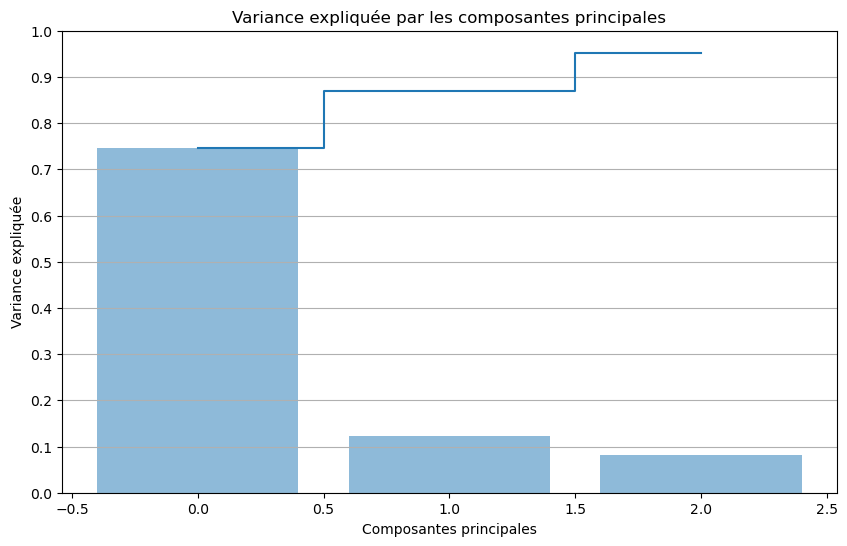

In [74]:
# 9) ACP
n_components = 3
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_train_clean.drop(columns=['DELIVERY_START']))

# Affichage des résultats de l'ACP
plt.figure(figsize=(10, 6))
plt.bar(range(n_components), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(n_components), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.xlabel('Composantes principales')
plt.ylabel('Variance expliquée')
plt.title('Variance expliquée par les composantes principales')
plt.ylim(0,1)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True, axis='y') 
plt.show()



In [76]:
Z_train_clean = (y_train_clean.groupby('DELIVERY_START')['spot_id_delta'].sum() + 
     X_train_clean.groupby('DELIVERY_START')['predicted_spot_price'].sum())
Z_train_clean = Z_train_clean.to_frame()
Z_train_clean = Z_train_clean.rename(columns={Z_train_clean.columns[0]: 'intraday'})
Z_train_clean = Z_train_clean['intraday'].values
len(Z_train_clean)

1457

In [118]:
def tendancy(Z):
    W = np.zeros_like(Z)
    for i in range(1,len(Z)):
        W[i] = np.sign(Z[i] - Z[i-1])
        if W[i] < 1 :
            W[i] += 1
    return W

W_train = tendancy(Z_train_clean)


In [122]:
def counter(W):
    c0, c1 = 0, 0
    for i in range(len(W)):
        if W[i] == 0 :
            c0 += 1
        else:
            c1 += 1
    return c0, c1

c0, c1 = counter(W_train)
print(" c0 : ", c0)
print(" c1 : ", c1)

 c0 :  815
 c1 :  642


In [125]:
# Initialiser les modèles
svm = SVC()
random_forest = RandomForestClassifier()
adaboost = AdaBoostClassifier()
xgboost = XGBClassifier()

# Initialiser le VotingClassifier
voting_clf = VotingClassifier(estimators=[('svm', svm), ('random_forest', random_forest), 
                                          ('adaboost', adaboost), ('xgboost', xgboost)], 
                              voting='hard')

# Entraîner les modèles
svm.fit(X_pca, W_train)
random_forest.fit(X_pca, W_train)
adaboost.fit(X_pca, W_train)
xgboost.fit(X_pca, W_train)
voting_clf.fit(X_pca, W_train)

models = {'SVM': svm, 'Random Forest': random_forest, 'AdaBoost': adaboost, 'XGBoost': xgboost, 'Voting Classifier': voting_clf}

for name, model in models.items():
    y_pred = model.predict(X_pca)
    accuracy = accuracy_score(W_train, y_pred)
    recall = recall_score(W_train, y_pred, average='macro')
    confusion = confusion_matrix(W_train, y_pred)
    print(f"Modèle: {name}")
    print(f"Accuracy: {accuracy}")
    print(f"Recall: {recall}")
    print(f"Matrice de confusion:\n {confusion}")


Modèle: SVM
Accuracy: 0.5593685655456417
Recall: 0.5
Matrice de confusion:
 [[815   0]
 [642   0]]
Modèle: Random Forest
Accuracy: 1.0
Recall: 1.0
Matrice de confusion:
 [[815   0]
 [  0 642]]
Modèle: AdaBoost
Accuracy: 0.6183939601921757
Recall: 0.5906188483076276
Matrice de confusion:
 [[672 143]
 [413 229]]
Modèle: XGBoost
Accuracy: 0.9601921757035004
Recall: 0.9573084494390612
Matrice de confusion:
 [[800  15]
 [ 43 599]]
Modèle: Voting Classifier
Accuracy: 0.7144818119423473
Recall: 0.67601246105919
Matrice de confusion:
 [[815   0]
 [416 226]]


In [127]:
X_pca_test = pca.fit_transform(X_test_clean.drop(columns=['DELIVERY_START']))

Z_test_clean = (y_test_clean.groupby('DELIVERY_START')['spot_id_delta'].sum() + 
     X_test_clean.groupby('DELIVERY_START')['predicted_spot_price'].sum())
Z_test_clean = Z_test_clean.to_frame()
Z_test_clean = Z_test_clean.rename(columns={Z_test_clean.columns[0]: 'intraday'})
Z_test_clean = Z_test_clean['intraday'].values

W_test = tendancy(Z_test_clean)
c0, c1 = counter(W_test)
print(" c0 : ", c0)
print(" c1 : ", c1)

 c0 :  189
 c1 :  176


In [128]:
predictions = {}
for name, model in models.items():
    y_pred_test = model.predict(X_pca_test)
    predictions[name] = y_pred_test

# Comparer les prédictions avec W_test
for name, y_pred_test in predictions.items():
    accuracy = accuracy_score(W_test, y_pred_test)
    recall = recall_score(W_test, y_pred_test, average='macro')
    confusion = confusion_matrix(W_test, y_pred_test)
    print(f"Modèle: {name}")
    print(f"Accuracy: {accuracy}")
    print(f"Recall: {recall}")
    print(f"Matrice de confusion:\n {confusion}")

Modèle: SVM
Accuracy: 0.5178082191780822
Recall: 0.5
Matrice de confusion:
 [[189   0]
 [176   0]]
Modèle: Random Forest
Accuracy: 0.5232876712328767
Recall: 0.5174062049062049
Matrice de confusion:
 [[129  60]
 [114  62]]
Modèle: AdaBoost
Accuracy: 0.5013698630136987
Recall: 0.4931156806156806
Matrice de confusion:
 [[137  52]
 [130  46]]
Modèle: XGBoost
Accuracy: 0.5643835616438356
Recall: 0.5611922799422799
Matrice de confusion:
 [[123  66]
 [ 93  83]]
Modèle: Voting Classifier
Accuracy: 0.5287671232876713
Recall: 0.5154671717171717
Matrice de confusion:
 [[168  21]
 [151  25]]


In [ ]:
# 15) Courbes ROC
plt.figure(figsize=(10, 6))
for model, name in zip(models, model_names):
    y_score = model.predict_proba(X_test_clean.drop(columns=['DELIVERY_START', 'predicted_spot_price']))[:, 1]
    fpr, tpr, _ = roc_curve(y_test_clean['spot_id_delta'], y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy')